In [1]:
import numpy as np
import EI_subspace_RNN
import scipy.stats as stats
from utils import *
from plotting_utils import *
import matplotlib.pyplot as plt

# hyperparameters
N_e = 40
N_i = 40
N = N_e + N_i 
K = 3
J = np.random.normal(0, 1/np.sqrt(N), (N,N))
J, _ = np.linalg.qr(J)  # QR decomposition, Q is the orthogonal matrix
J = J[:K,:]
J_inv = np.linalg.pinv(J) # pseudo-inverse (J * J_inv = identity, but J_inv * J is not)
sparsity = 0.25
D = 12
U = 50
T = 500
N_weights = int (N * N * sparsity)
print(J.shape)
print(J @ J.T)

colormap = ['tab:purple','tab:pink','tab:cyan','yellowgreen', 'olive']

SyntaxError: invalid syntax (EI_subspace_RNN.py, line 94)

In [2]:
eigenvalues = np.array([0.9, - 0.1 + 0.5j, - 0.1 - 0.5j])
trueA = generate_dynamics_A(eigenvalues) # checked that A has above eigenvalues
print(trueA)

fig, axes = plt.subplots(figsize=(5,5))
axes.set_title('LDS target low-dim dynamics A')
plot_eigenvalues(axes, eigenvalues)

NameError: name 'generate_dynamics_A' is not defined

Text(0.5, 0, 'iteration')

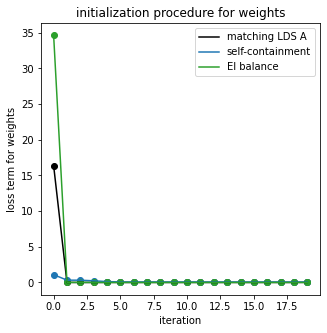

In [7]:
# Weight initialization - from true target LDS A
RNN = EI_subspace_RNN.EI_subspace_RNN(N_e, N_i, sparsity, J, seed=1)
alpha_beta_list = [10 ** i for i in list(np.arange(-4,1,0.25))]
initW, loss_W = RNN.generate_or_initialize_weights_from_dynamics_LDS(A_target=trueA, R=0.85, alpha_beta_list = alpha_beta_list)
init_w = RNN.get_nonzero_weight_vector(initW)
initA = build_dynamics_matrix_A(initW, J)

# verifiy that it has similar eigenstructure to A
fig, axes = plt.subplots(figsize=(5,5))
axes.plot(range(len(alpha_beta_list)), loss_W[:,0], color='black', label='matching LDS A')
axes.scatter(range(len(alpha_beta_list)), loss_W[:,0], color='black')
axes.plot(range(len(alpha_beta_list)), loss_W[:,1], color='tab:blue', label='self-containment')
axes.scatter(range(len(alpha_beta_list)), loss_W[:,1], color='tab:blue')
axes.plot(range(len(alpha_beta_list)), loss_W[:,2], color='tab:green', label='EI balance')
axes.scatter(range(len(alpha_beta_list)), loss_W[:,2], color='tab:green')
axes.legend()
axes.set_title('initialization procedure for weights')
axes.set_ylabel('loss term for weights')
axes.set_xlabel('iteration')

In [8]:
true_b, true_s, true_mu0, true_Q0, true_C_, true_d, true_R = RNN.generate_parameters(D, K)
x, y = RNN.generate_latents_and_observations(U, T, trueA, true_b, true_s, true_mu0, true_Q0, true_C_, true_d, true_R)
print(x.shape)
print(y.shape)

(50, 500, 3, 1)
(50, 500, 12, 1)


In [9]:
w, b, s, mu0, Q0, C_, d, R = RNN.fit_EM(y, init_w, true_b, true_s, true_mu0, true_Q0, true_C_, true_d, true_R, alpha=0, beta=0, max_iter=50)

0
10
20
30
40


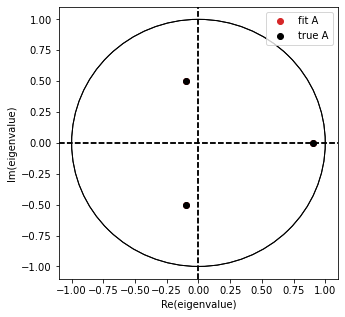

In [10]:
# recoevered eigenspectrum from weights
fig, axes = plt.subplots(figsize=(5,5))
W = RNN.build_full_weight_matrix(w)
fitA = build_dynamics_matrix_A(W, J)
plot_eigenvalues(axes, np.linalg.eigvals(fitA), color='tab:red', label='fit A')
plot_eigenvalues(axes, np.linalg.eigvals(trueA), color='black', label='true A')
axes.legend()
plt.show()

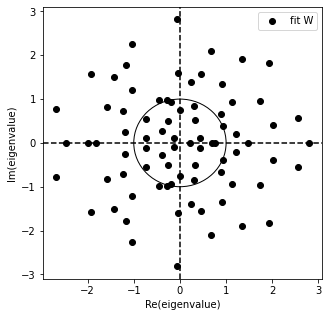

In [14]:
# recoevered eigenspectrum from weights
fig, axes = plt.subplots(figsize=(5,5))
plot_eigenvalues(axes, np.linalg.eigvals(W), color='black', label='fit W')
axes.legend()

In [18]:
# generate network activity from fit W
v = RNN.generate_network_activity(U, T, W, b, s, mu0, Q0)
print(v.shape)

(50, 500, 80, 1)


In [20]:
print(np.isinf(v).sum())

0


In [37]:
print(np.isnan(v_concat).sum())

0


In [40]:
# PCA on network activity
v_concat = v.reshape(v.shape[0] * v.shape[1], v.shape[2])
y_concat = y.reshape(y.shape[0] * y.shape[1], y.shape[2])
print(v_concat)
# v_avg = v.mean(axis=0).reshape(v.shape[1], v.shape[2])
# mean = v_avg.mean(axis=0)
mean = v_concat.mean(axis=0)

# mean-center
v_concat = v_concat - mean
# v_mean = v_avg - mean

eigval, eigvec = np.linalg.eig(v_concat.T @ v_concat) # eigvec 0 is eigvec[:,0] - columns
ones = np.ones((v_concat.shape[1]))
print(angle_vectors(ones, eigvec[:,0]))

# eigval, eigvec = np.linalg.eig(v_mean.T @ v_mean) # eigvec 0 is eigvec[:,0] - columns
# ones = np.ones((v_mean.shape[1]))

fig, axes = plt.subplots(figsize=(5,6))
for k in range(K):
    axes.axhline(angle_vectors(ones, eigvec[:,k]), color=colormap[k], label=f'PCA comp {k+1}', linewidth=3)
axes.axhline(90, color='black', linestyle='dashed', label='chance')
eps = 0.01
axes.set_xlim(0-eps, np.pi + eps)
axes.set_ylabel('angle with co-activation pattern (deg)')
axes.set_ylim(0,180)
axes.set_xlim(-1,1)
axes.set_xticks([],[])
axes.set_yticks([0,30,60,90,120,150,180],[0,30,60,90,120,150,180])
axes.legend()
plt.show()


[[-2.44003022e-001 -8.80427681e-001 -5.67205866e-001 ... -7.15366836e-001
   4.15894738e-001 -1.11871454e+000]
 [-5.24103350e-001 -1.80475337e+000 -2.62217913e+000 ... -7.31714276e+000
   1.38783661e+000 -1.26554969e-001]
 [ 5.26064585e+000 -4.84907771e+000 -3.95461875e+000 ...  1.44335283e+001
   1.53462442e+000  5.85682474e+000]
 ...
 [-3.29879806e+222  1.74161712e+222  2.62334951e+222 ... -7.68119675e+222
  -4.34705870e+221 -2.30526378e+222]
 [-5.36988045e+222  1.43070238e+223  9.65694397e+222 ... -2.28337922e+223
   8.13077670e+222  6.56719020e+222]
 [ 1.90027879e+223  1.67811667e+223  6.46510288e+222 ...  3.28816267e+223
  -2.78041098e+223  2.15749031e+223]]


/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_80721/2599186694.py:13: RuntimeWarning: overflow encountered in matmul
  eigval, eigvec = np.linalg.eig(v_concat.T @ v_concat) # eigvec 0 is eigvec[:,0] - columns
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_80721/2599186694.py:13: RuntimeWarning: invalid value encountered in matmul
  eigval, eigvec = np.linalg.eig(v_concat.T @ v_concat) # eigvec 0 is eigvec[:,0] - columns


LinAlgError: Array must not contain infs or NaNs

In [2]:
print(true_s)

NameError: name 'true_s' is not defined

In [33]:
def projection_on_vector(v,u):
    ''' 
    projecting v on u
    '''
    return np.dot(u,v)/ (np.linalg.norm(u) ** 2) * u, np.dot(u,v)/ np.linalg.norm(u)

def projection_on_subspace(v,U):
    ''' 
    projecting v on U, U orthogonal
    '''
    print(v.shape)
    print(U.shape)
    v_proj = np.linalg.pinv(U) @ U @ v
    angle = np.rad2deg(np.arccos(np.dot(v, v_proj) / (np.linalg.norm(v) * np.linalg.norm(v_proj))))
    return v_proj, angle


(12,)
(3, 80)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 12 is different from 80)

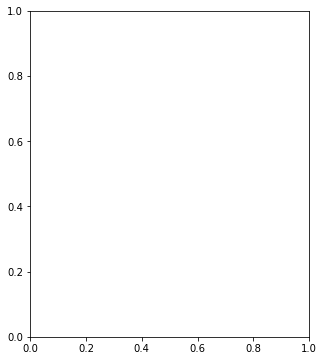

In [34]:
fig, axes = plt.subplots(figsize=(5,6))
for k in range(K):
    v_proj, angle = projection_on_subspace(eigvec[:,k],J)
    axes.axhline(np.linalg.norm(v_proj)/np.linalg.norm(eigvec[:,k]), color=colormap[k], label=f'PCA comp {k+1}')

axes.axhline(np.sqrt(K/N), color='black', linestyle='dashed', label='chance = sqrt(K/N)')
axes.set_ylabel('length of projection on subspace J')
# axes.set_ylim(0,120)
axes.set_xticks([],[])
# axes.set_yticks([0,30,60,90,120],[0,30,60,90,120])
axes.legend()

In [1]:
fig, axes = plt.subplots(figsize=(5,6))
for k in range(K):
    v_proj, angle = projection_on_subspace(eigvec[:,k],J)
    axes.axhline(angle, color=colormap[k], label=f'PCA comp {k+1}')

axes.axhline(90, color='black', linestyle='dashed', label='orthogonal')
axes.set_ylabel('angle with subspace J')
axes.set_ylim(0,120)
axes.set_xticks([],[])
# axes.set_yticks([0,30,60,90,120],[0,30,60,90,120])
axes.legend()

NameError: name 'plt' is not defined

In [22]:
# # PCA on neural activity
# # y_concat = y.reshape(y.shape[0] * y.shape[1], y.shape[2])
# y_avg = y.mean(axis=0).reshape(y.shape[1], y.shape[2])
# mean = y_avg.mean(axis=0)

# # mean-center
# # y_concat = y_concat - mean
# y_mean = y_avg - mean

# # eigval, eigvec = np.linalg.eig(y_concat.T @ y_concat) # eigvec 0 is eigvec[:,0] - columns
# # ones = np.ones((y_concat.shape[1]))
# # print(angle_vectors(ones, eigvec[:,0]))

# eigval, eigvec = np.linalg.eig(y_mean.T @ y_mean) # eigvec 0 is eigvec[:,0] - columns
# ones = np.ones((y_mean.shape[1]))
# print(angle_vectors(ones, eigvec[:,0]))
# print(np.pi/2)
# print(np.pi)

